### 1. Set up the environment

In [68]:
import numpy as np 
import pandas as pd 
import pandas_datareader as pdr 
import matplotlib.pyplot as plt 
from matplotlib import rcParams
rcParams['figure.figsize'] = 8,6
import seaborn as sb
sb.set()
import yfinance as yf
yf.pdr_override()

### 2. Download stock price data, store in a dataframe

In [12]:
#amzn = pdr.data.get_data_yahoo('AAPL')
amzn = pdr.data.get_data_yahoo('AMZN')


[*********************100%***********************]  1 of 1 completed


### 3. Take a look at the data

In [69]:
amzn.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


### 4. Store instantaneous rate of return in separate series


In [70]:
amzn_close = amzn['Close']
amzn_return = round(np.log(amzn_close).diff() * 100, 2)
amzn_return.head()

Date
1997-05-15      NaN
1997-05-16   -12.45
1997-05-19    -1.21
1997-05-20    -4.36
1997-05-21   -13.63
Name: Close, dtype: float64

### 5. Plot the series

<AxesSubplot:xlabel='Date'>

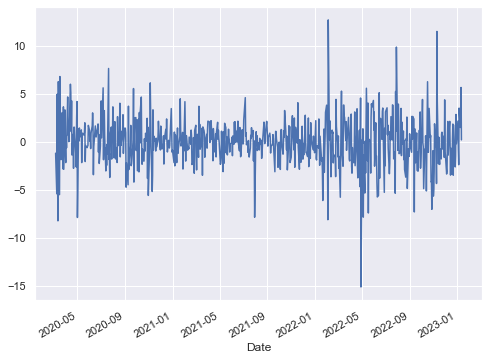

In [71]:
amzn_return[-720:].plot()

### 6. Pandas describe function gives descriptive statistics, default assumes you are dealing with a sample Pandas also deals woth missing values by omitting them

In [72]:
amzn_return.dropna(inplace=True)
amzn_return.describe()

count    6458.000000
mean        0.106576
std         3.570051
min       -28.460000
25%        -1.340000
50%         0.040000
75%         1.470000
max        29.620000
Name: Close, dtype: float64

### 7. An alternative slightly different table of descriptives from scipy stats

In [73]:
from scipy import stats 

In [74]:
n, minmax, mean, var, skew, kurt = stats.describe(amzn_return)
mini, maxi = minmax # Unpack the minmax tuple
std = var ** 0.5

### 9. For comparison generate random numbers that follow normal distribution 

In [75]:
from scipy.stats import norm 

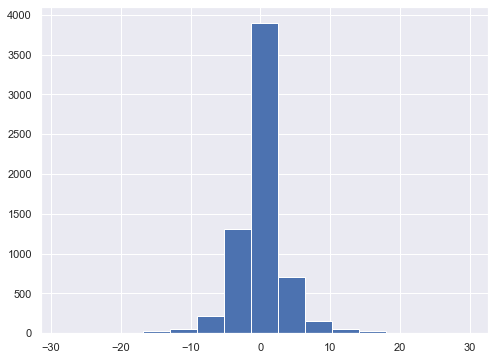

In [76]:
plt.hist(amzn_return, bins=15);

In [77]:
# Lets generate a random normal distribution to compare to
from scipy.stats import norm
x = norm.rvs(mean, std, n)


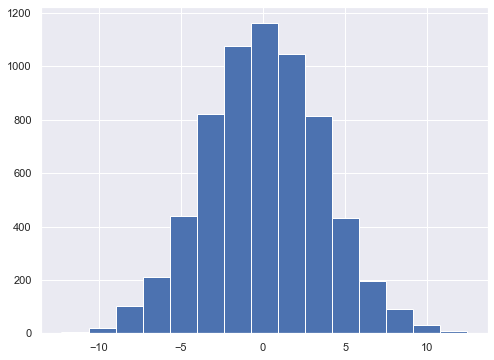

In [78]:
plt.hist(x, bins = 15);

## Is price change normally distributed?

### 10. Use scipy stats to test the kurtosis, the null hypothesis is that the sample is drawn from a population where the underlying kurtosis is that of a normally distributed variable

In [79]:
x_test = stats.kurtosistest(x)
amzn_test = stats.kurtosistest(amzn_return)
print(f'{"    Test statistic":20}{"p-value":>15}')
print(f'{" "*5}{"-"* 30}')
print(f'x:{x_test[0]:>17.2f}{x_test[1]:16.4f}')
print(f"AMZN: {amzn_test[0]:13.2f}{amzn_test[1]:16.4f}")

    Test statistic          p-value
     ------------------------------
x:            -1.01          0.3146
AMZN:         32.81          0.0000


### 11. Plot histogram of price changes with normal curve overlay

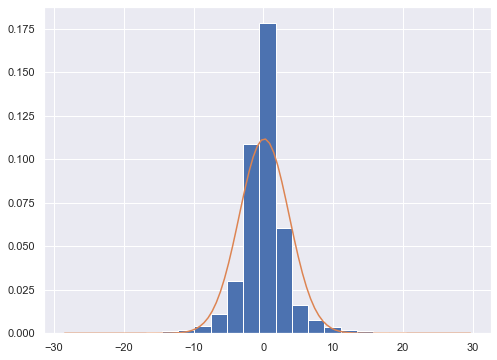

In [80]:
plt.hist(amzn_return, bins=25, edgecolor='w', density=True)
overlay = np.linspace(mini, maxi, 100)
plt.plot(overlay, norm.pdf(overlay, mean, std));

## Is daily price change significantly different from zero?

### 13. Conduct simple hypothesis test

In [81]:
stats.ttest_1samp(amzn_return.sample(252), 0, alternative = 'two-sided')


Ttest_1sampResult(statistic=3.2103503597769167, pvalue=0.001498596023083227)

## Can price movement be described as a random walk?

### 14. Create price lags 

In [82]:
amzn_close = pd.DataFrame(amzn_close, columns = ['Close'])
amzn_close['lag_1'] = amzn_close.Close.shift(1)
amzn_close['lag_2'] = amzn_close.Close.shift(2)
amzn_close.dropna(inplace=True)

amzn_close.head()

,Close,lag_1,lag_2
Date,,,
1997-05-19,0.085417,0.086458,0.097917
1997-05-20,0.081771,0.085417,0.086458
1997-05-21,0.071354,0.081771,0.085417
1997-05-22,0.069792,0.071354,0.081771
1997-05-23,0.075000,0.069792,0.071354


### 15. Fit linear model

In [83]:
lr = np.linalg.lstsq(amzn_close[['lag_1', 'lag_2']], amzn_close['Close'], rcond= None)[0]

In [86]:
amzn_close['predict'] = np.dot(amzn_close[['lag_1', 'lag_2']], lr)
amzn_close.tail()

,Close,lag_1,lag_2,predict
Date,,,,
2023-01-06,86.080002,83.120003,85.139999,83.152342
2023-01-09,87.360001,86.080002,83.120003,86.030471
2023-01-10,89.870003,87.360001,86.080002,87.338065
2023-01-11,95.089996,89.870003,87.360001,89.827828
2023-01-12,95.269997,95.089996,89.870003,95.003233


<AxesSubplot:xlabel='Date'>

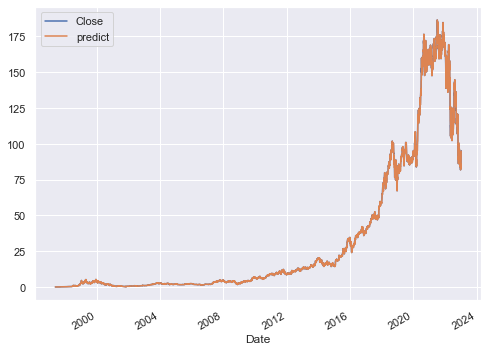

In [85]:
amzn_close[['Close', 'predict']].plot()

<AxesSubplot:xlabel='Date'>

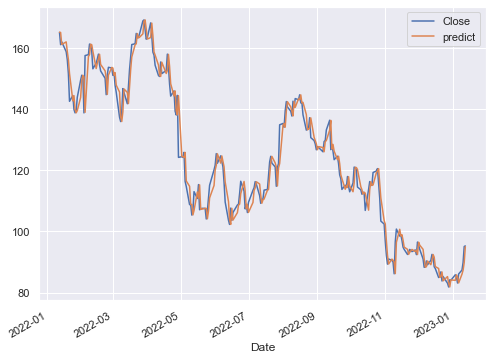

In [87]:
amzn_close.iloc[-252:][['Close', 'predict']].plot()